### PCA to CAE's coding layer

In this notebook we took the coding activation of a convolutional autoencoder (CAE) and perform PCA for further data compression.

The idea is to use this PCA transformation as an additional compression layer in the original autoencoder. Note that PCA transformations are equivalent to a Linear layer without any activation function.

In particular, we are going to use the Average_CAE_deep model, with a coding of size 256x8x8.
To perform PCA we first flatten the array, which results in 16384 features.

The idea is to use 1024 components of the PCA transformation.

In [2]:
import numpy as np

import math
import pickle
import matplotlib.pyplot as plt

In [72]:
# we load the coding output extracted from Average_CAE
coding_filepath = 'coding_Average_CAE_deep-256x8x8.pkl'
coding_act = np.load(coding_filepath)

In [73]:
# (samples, num feature maps, feature map shape)
coding_act.shape

(6400, 256, 8, 8)

In [74]:
# flatten the feature maps
coding_act_flat = coding_act.reshape(6400, -1)
coding_act_flat.shape

(6400, 16384)

In [75]:
# check simple properties of the coding layer:
# zero elements
print(f'coding zero elements: {np.sum(abs(coding_act_flat) < 10e-10)}')
print(f'positive: {np.sum(coding_act_flat > 0)}')
print(f'negative: {np.sum(coding_act_flat < 0)}')

coding zero elements: 0
positive: 14690987
negative: 90166613


In [76]:
# Plot the feature maps all together
all_feat = np.zeros((16*8, 16*8))
for i, feature in enumerate(np.mean(coding_act, axis = 0)):
    block_row = i // 16
    block_col = i % 16
    all_feat[block_row*8:block_row*8 + 8, block_col*8:block_col*8 + 8] = feature

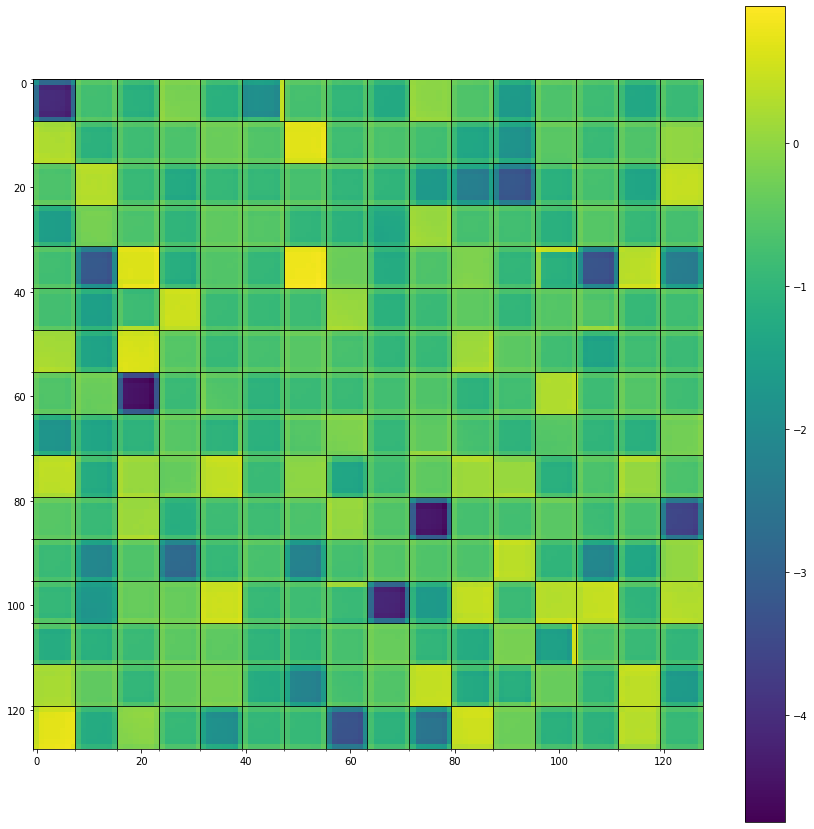

In [77]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
feat = ax.imshow(all_feat)
fig.colorbar(feat, ax=ax,)
# ax.grid(True, c='black')

# Major ticks every 20, minor ticks every 5
# major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 128, 8) - 0.7

# ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
# ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', c='black')

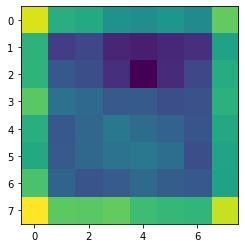

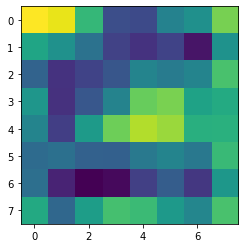

In [78]:
# plt.imshow(all_feat[:8,:8])
plt.imshow(coding_act[2,40,:,:])
plt.show()
plt.imshow(coding_act[0,2,:,:])

### PCA

Done with the coding layer overview, we now proceed to do PCA on the coding layer

In [79]:
from numpy import linalg as LA
from numpy import cov
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features shape before(6400, 16384)
100
features shape after(6400, 100)


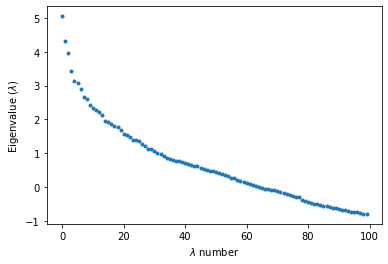

In [80]:
# level of compression:
num_components = 100

x = coding_act_flat

print(f'features shape before{x.shape}')

# print(features.shape)
# features_ts = scaler.fit_transform(features)
x_centered = x - np.mean(x, axis=0)

# Using scipy package

# percentage of variance explained: PCA(0.95)
# can also use: PCA(n_components=2)
pca = PCA(n_components = num_components)
x_centered = pca.fit_transform(x_centered)
# pca.explained_variance_ are the eigenvalues
eigenvalues = pca.explained_variance_ 
print(len(eigenvalues))
# pca.components_ are the eigenvectors
# print(pca.components_[1,:])

print(f'features shape after{x_centered.shape}')

# Plot eigenvalues 
plt.plot(np.log(eigenvalues), '.')
plt.ylabel('Eigenvalue $(\lambda)$')
plt.xlabel('$\lambda$ number')
plt.show()

In [81]:
mean_arr = np.mean(x, axis=0)
mean_arr = mean_arr[np.newaxis,:]
mean_mat = np.repeat(mean_arr, 6400, axis = 0)

In [82]:
x.shape
x_trans = pca.transform(x)
mean_trans = pca.transform(mean_mat)

In [83]:
(x_trans - mean_trans)[0,:20]

array([ 8.09785461e+00,  1.03483658e+01,  1.30481348e+01,  1.24962473e+00,
        6.63805008e-03,  1.34688091e+00, -4.29738998e+00, -7.58760452e+00,
        3.73587704e+00,  6.34287930e+00,  5.27660799e+00,  4.91039276e-01,
       -4.77690315e+00,  1.87303829e+00, -5.25512743e+00, -4.70070219e+00,
        8.83816910e+00,  1.01358509e+00,  1.37341881e+00,  1.04234695e-01],
      dtype=float32)

In [84]:
x_centered[0,:20]

array([ 8.0978069e+00,  1.0348448e+01,  1.3048152e+01,  1.2496200e+00,
        6.6359676e-03,  1.3468946e+00, -4.2973757e+00, -7.5876107e+00,
        3.7358892e+00,  6.3428984e+00,  5.2766066e+00,  4.9104831e-01,
       -4.7769094e+00,  1.8730435e+00, -5.2551360e+00, -4.7007017e+00,
        8.8381643e+00,  1.0135787e+00,  1.3734138e+00,  1.0422947e-01],
      dtype=float32)

Although repetitive, we do the pca.transform explictily just to understand that the pca.components_ is the information that we need to define the neural network equivalent to PCA:

In [ ]:
# pca.components_ is the matrix of eigenvectores V^T in our notation: each row is an eigenvector
pca.components_.shape
x_test = np.dot(x-mean_arr, pca.components_.T)
x_test[0,:20]

### PCA as NN

We want to find the direction which maximizes the variance of a given dataset $X$. For simplicity we will asume $X$ is centered, this is $X = X - X_{mean}$.

The variance on a given direction can be expressed as follows:

$w^T X^T X w$,

where $w$ is the unitary vector representing the direction. Note that $X^T X$ is the covariance matrix.

So, reformulating the problem, we want to find 

$\text{max}_w$ $w^T C w$, where C is the covariance matrix.

From the spectral theorem we have that

$\text{C} = V D V^T$.

Instead we will use singular value decomposition as it is more numerically stable:

$X = USV^T$

$C = X^TX = VSU^TUSV^T$

$    X^TX = V S^2 V^T$
    
The PCA linear transformation is defined as follows:

$XV = US$,

where $X_{n,m}$, $V_{m,k}$. $k$ is number of components.



In [86]:
import torch
import torch.nn as nn

In [87]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pca_encoder = nn.Linear(16384, num_components)
        self.pca_decoder = nn.Linear(num_components, 16384)
    def forward(self, input):
        x = self.pca_encoder(input)
#         x = self.pca_decoder(x)
        return x


In [88]:
pca_net = Net()

### PCA and NN equivalence
The procedure is straight forward.

* PCA projection:

z = $V^T (x - \bar{x})$,

where $x \in \mathbb{R}^{16384x1}$ is the input, $\bar{x} \in \mathbb{R}^{16384x1}$ is the mean of each feature, and $V^T \in \mathbb{R}^{1024x16384}$ is the covariance eigenvector's matrix. Note that 1024 means that we choose the first 1024 eigenvectors to do the projection. This step is the dimensionality reduction step.

* NN projection:

We have a linear layer which performs the following operation to the input x:

$z = \omega x + \beta$.

So, to make it equivalent to the PCA projection:

$\omega = V^T$, 
$\beta = V^T \bar{x}$.

For the decoder we have the following transformation:

$z' = \omega' z + \beta'$

We want to recover the original input from

$x = z' = \omega' (V^T x - V^T\bar{x}) + \beta'$,

we get that

$\omega' = V$, 
$\beta' = \bar{x}$.

To be rigorous, the x we get as output is not the same as the input. There was a loss of information when projecting the data in the first 1024 eigenvectors.



In [89]:
pca_dict = {}
pca_dict['pca_encoder.weight'] = torch.tensor(pca.components_)
pca_dict['pca_encoder.bias'] = - torch.tensor(np.squeeze(np.dot(pca.components_, mean_arr.T)))
pca_dict['pca_decoder.weight'] = torch.tensor(pca.components_.T)
pca_dict['pca_decoder.bias'] = torch.tensor( np.squeeze(mean_arr.T))

In [90]:
model_dict = pca_net.state_dict()
for k,v in model_dict.items():
    print(k, v.shape)

print(pca_dict['pca_encoder.bias'][:10])
print(model_dict['pca_encoder.bias'][:10])
# mean_arr.shape

pca_encoder.weight torch.Size([100, 16384])
pca_encoder.bias torch.Size([100])
pca_decoder.weight torch.Size([16384, 100])
pca_decoder.bias torch.Size([16384])
tensor([ -68.1094, -108.9005,   -9.1486,    7.6990,   -2.7269,   -4.7023,
           3.9850,   11.8172,    3.5264,    2.3314])
tensor([ 0.0043,  0.0060, -0.0027, -0.0065,  0.0019,  0.0072, -0.0015,  0.0032,
         0.0024, -0.0059])


In [91]:
model_dict.update(pca_dict)

print(pca_dict['pca_encoder.bias'][:10])
print(model_dict['pca_encoder.bias'][:10])

tensor([ -68.1094, -108.9005,   -9.1486,    7.6990,   -2.7269,   -4.7023,
           3.9850,   11.8172,    3.5264,    2.3314])
tensor([ -68.1094, -108.9005,   -9.1486,    7.6990,   -2.7269,   -4.7023,
           3.9850,   11.8172,    3.5264,    2.3314])


In [92]:
pca_net.load_state_dict(model_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [93]:
pca_net(torch.tensor(x))

tensor([[ 8.0979e+00,  1.0348e+01,  1.3048e+01,  ..., -8.0977e-01,
         -2.4873e-02,  1.0601e+00],
        [-3.1990e+00, -1.5323e+00,  9.7733e+00,  ..., -5.5968e-01,
         -7.4901e-02,  4.0294e-02],
        [ 4.8563e+00,  8.1090e+00,  1.0404e+01,  ...,  1.6729e+00,
         -6.0661e-01,  1.2305e+00],
        ...,
        [-1.3785e+00,  2.7468e+00, -5.8398e+00,  ...,  6.8593e-02,
          1.7100e-01, -1.1389e+00],
        [ 9.5453e+00,  3.3746e+00, -8.5456e+00,  ..., -9.6329e-02,
         -4.9045e-01,  1.6234e+00],
        [-1.3517e+01,  1.1369e+01, -1.0290e+00,  ..., -9.1988e-04,
         -5.5994e-02,  2.3993e-01]], grad_fn=<AddmmBackward>)

In [94]:
x_centered

array([[ 8.0978069e+00,  1.0348448e+01,  1.3048152e+01, ...,
        -8.0976856e-01, -2.4872897e-02,  1.0600728e+00],
       [-3.1989787e+00, -1.5323439e+00,  9.7732964e+00, ...,
        -5.5968839e-01, -7.4900880e-02,  4.0294874e-02],
       [ 4.8563032e+00,  8.1090345e+00,  1.0404023e+01, ...,
         1.6728903e+00, -6.0661417e-01,  1.2305202e+00],
       ...,
       [-1.3784162e+00,  2.7467821e+00, -5.8397875e+00, ...,
         6.8588622e-02,  1.7099956e-01, -1.1388824e+00],
       [ 9.5453081e+00,  3.3745620e+00, -8.5455694e+00, ...,
        -9.6333921e-02, -4.9044928e-01,  1.6233684e+00],
       [-1.3516681e+01,  1.1368983e+01, -1.0289986e+00, ...,
        -9.2331489e-04, -5.5996113e-02,  2.3992902e-01]], dtype=float32)

In [95]:
# Save PCA weights in a dictionary. 
# For simplicity, we set the dictionary keys to be compatible with the CAE NN implementation.


pca_filepath = 'pca-100_' + coding_filepath

torch.save(pca_dict, pca_filepath)



### PCA with NN example

In [26]:
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data as utils
from tqdm import tqdm


In [27]:
# data
x = np.linspace(-1,1,10000)

def noisy_lin(x,m,b):
    y = m*x + b + np.random.normal(loc=0.0, scale=0.02, size=len(x))
    return y

y = noisy_lin(x,1,0)

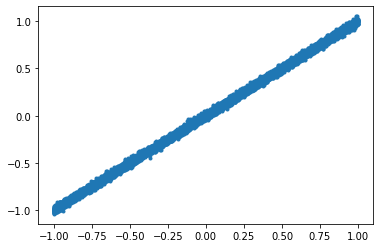

In [28]:
# plot of noisy input data
plt.plot(x,y, '.')

In [29]:
# define architecture
class NetPCA(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(2, 1)
        self.decoder = nn.Linear(1, 2)
    def forward(self, input):
        x = self.encoder(input)
        x = self.decoder(x)
        return x

In [30]:
y = y[np.newaxis, :]
x = x[np.newaxis, :]

# stack the data to use it as input of the neural network
data = np.vstack((x,y)).T

print(data.shape)

(10000, 2)


In [31]:
# tensor_x = torch.from_numpy(x).float()
# tensor_y = torch.from_numpy(y).float()

tensor_data = torch.from_numpy(data).float()

my_dataset = utils.TensorDataset(tensor_data) # create your datset
my_dataloader = utils.DataLoader(my_dataset, batch_size = 4) # create your dataloader

# tensor_x.shape

In [32]:
next(iter(my_dataloader))

[tensor([[-1.0000, -0.9658],
         [-0.9998, -0.9867],
         [-0.9996, -1.0153],
         [-0.9994, -1.0400]])]

In [33]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = NetPCA().to(device)


In [34]:
num_epochs = 20
lr = 0.05
print_freq = 1

In [35]:
# loss function
criterion = nn.MSELoss()

# optimizer algorithm
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [36]:
for it, epoch in enumerate(range(num_epochs)):
    # Ensure dropout layers are in train mode
    model.train()

    # batch forward pass
    for i_batch, batch in tqdm(enumerate(my_dataloader)):
        # _ should be the target, which for cae its the image itself        
        x = batch[0].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(x)
        # calculate the loss
        loss = criterion(outputs, x)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

            
        # Print status
        if (i_batch + 1) % (len(my_dataloader) // print_freq) == 0:
            print(f'Epoch: [{epoch}] [{i_batch + 1}/ {len(my_dataloader)}] \t  \
                     Train Loss: {loss.item():.4f} ')
#             print(f'Train Loss: {loss.item()}')


2500it [00:00, 2812.34it/s]
246it [00:00, 2456.71it/s]

Epoch: [0] [2500/ 2500] 	                       Train Loss: 0.0002 


2500it [00:00, 2932.91it/s]
299it [00:00, 2981.44it/s]

Epoch: [1] [2500/ 2500] 	                       Train Loss: 0.0001 


2500it [00:00, 2998.85it/s]
298it [00:00, 2978.86it/s]

Epoch: [2] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 3007.53it/s]
303it [00:00, 3025.63it/s]

Epoch: [3] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 3021.40it/s]
303it [00:00, 3027.52it/s]

Epoch: [4] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 3022.28it/s]
299it [00:00, 2982.36it/s]

Epoch: [5] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 3003.53it/s]
303it [00:00, 3022.27it/s]

Epoch: [6] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 2782.21it/s]
261it [00:00, 2606.32it/s]

Epoch: [7] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 2790.39it/s]
301it [00:00, 3009.95it/s]

Epoch: [8] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2092.16it/s]
215it [00:00, 2146.43it/s]

Epoch: [9] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1808.13it/s]
212it [00:00, 2115.44it/s]

Epoch: [10] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1759.35it/s]
198it [00:00, 1974.15it/s]

Epoch: [11] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1878.54it/s]
202it [00:00, 2017.12it/s]

Epoch: [12] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1825.62it/s]
153it [00:00, 1517.73it/s]

Epoch: [13] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1342.05it/s]
126it [00:00, 1251.69it/s]

Epoch: [14] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1389.40it/s]
182it [00:00, 1816.85it/s]

Epoch: [15] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1485.18it/s]
165it [00:00, 1641.88it/s]

Epoch: [16] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1546.23it/s]
192it [00:00, 1917.62it/s]

Epoch: [17] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1653.97it/s]
197it [00:00, 1963.55it/s]

Epoch: [18] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1730.60it/s]
218it [00:00, 2171.70it/s]

Epoch: [19] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 2745.12it/s]
301it [00:00, 3003.94it/s]

Epoch: [20] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 3043.93it/s]
310it [00:00, 3097.93it/s]

Epoch: [21] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 2811.43it/s]
247it [00:00, 2464.46it/s]

Epoch: [22] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2331.25it/s]
198it [00:00, 1969.29it/s]

Epoch: [23] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1632.81it/s]
197it [00:00, 1961.35it/s]

Epoch: [24] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:00, 2602.86it/s]
299it [00:00, 2984.35it/s]

Epoch: [25] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2252.25it/s]
140it [00:00, 1399.09it/s]

Epoch: [26] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1574.51it/s]
117it [00:00, 1163.86it/s]

Epoch: [27] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1685.39it/s]
180it [00:00, 1794.80it/s]

Epoch: [28] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1755.82it/s]
164it [00:00, 1637.74it/s]

Epoch: [29] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1482.96it/s]
133it [00:00, 1329.21it/s]

Epoch: [30] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1440.33it/s]
211it [00:00, 2101.04it/s]

Epoch: [31] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1644.59it/s]
184it [00:00, 1837.40it/s]

Epoch: [32] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1501.82it/s]
199it [00:00, 1985.78it/s]

Epoch: [33] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2342.29it/s]
299it [00:00, 2982.10it/s]

Epoch: [34] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2475.06it/s]
194it [00:00, 1933.16it/s]

Epoch: [35] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2076.14it/s]
198it [00:00, 1972.35it/s]

Epoch: [36] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1416.09it/s]
197it [00:00, 1962.15it/s]

Epoch: [37] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1929.58it/s]
295it [00:00, 2941.95it/s]

Epoch: [38] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1754.84it/s]
182it [00:00, 1818.78it/s]

Epoch: [39] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1391.93it/s]
185it [00:00, 1849.23it/s]

Epoch: [40] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1728.60it/s]
189it [00:00, 1886.02it/s]

Epoch: [41] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1726.97it/s]
186it [00:00, 1854.55it/s]

Epoch: [42] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2167.20it/s]
223it [00:00, 2228.86it/s]

Epoch: [43] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2035.62it/s]
236it [00:00, 2352.30it/s]

Epoch: [44] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1670.76it/s]
169it [00:00, 1687.13it/s]

Epoch: [45] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1781.42it/s]
203it [00:00, 2023.23it/s]

Epoch: [46] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2169.38it/s]
156it [00:00, 1558.46it/s]

Epoch: [47] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1679.65it/s]
172it [00:00, 1717.18it/s]

Epoch: [48] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 2362.45it/s]

Epoch: [49] [2500/ 2500] 	                       Train Loss: 0.0000 


[[-0.549707  -0.5038699]]


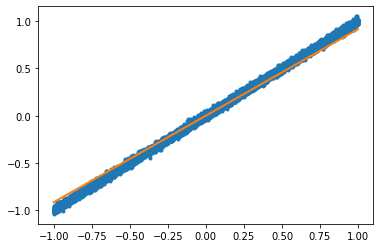

In [37]:
eigenvec = model.state_dict()['encoder.weight'].numpy()
print(eigenvec)

# eigenvec.shape

plt.plot(data[:,0],data[:,1], '.')
plt.plot(data[:,0],(eigenvec[0][1]/eigenvec[0][0])*data[:,0], lw = 2)

In [38]:
next(iter(my_dataloader))[0]

tensor([[-1.0000, -0.9658],
        [-0.9998, -0.9867],
        [-0.9996, -1.0153],
        [-0.9994, -1.0400]])

In [39]:
# Output of the model

model.eval()

out = []
# batch forward pass
for i_batch, batch in tqdm(enumerate(my_dataloader)):
    print(batch[0])
    out.append(model(batch[0]))

192it [00:00, 974.25it/s] 

tensor([[-1.0000, -0.9658],
        [-0.9998, -0.9867],
        [-0.9996, -1.0153],
        [-0.9994, -1.0400]])
tensor([[-0.9992, -0.9556],
        [-0.9990, -1.0129],
        [-0.9988, -0.9907],
        [-0.9986, -0.9918]])
tensor([[-0.9984, -1.0144],
        [-0.9982, -1.0186],
        [-0.9980, -0.9816],
        [-0.9978, -1.0299]])
tensor([[-0.9976, -0.9920],
        [-0.9974, -1.0004],
        [-0.9972, -1.0022],
        [-0.9970, -0.9953]])
tensor([[-0.9968, -0.9967],
        [-0.9966, -1.0259],
        [-0.9964, -0.9893],
        [-0.9962, -0.9841]])
tensor([[-0.9960, -1.0052],
        [-0.9958, -1.0160],
        [-0.9956, -1.0022],
        [-0.9954, -0.9635]])
tensor([[-0.9952, -0.9996],
        [-0.9950, -1.0030],
        [-0.9948, -0.9768],
        [-0.9946, -1.0265]])
tensor([[-0.9944, -1.0011],
        [-0.9942, -0.9730],
        [-0.9940, -0.9769],
        [-0.9938, -1.0208]])
tensor([[-0.9936, -0.9589],
        [-0.9934, -1.0051],
        [-0.9932, -0.9919],
        [-0.

458it [00:00, 1127.94it/s]

tensor([[-0.8464, -0.8304],
        [-0.8462, -0.8330],
        [-0.8460, -0.8711],
        [-0.8458, -0.8295]])
tensor([[-0.8456, -0.8448],
        [-0.8454, -0.8388],
        [-0.8452, -0.8624],
        [-0.8450, -0.8556]])
tensor([[-0.8448, -0.8752],
        [-0.8446, -0.8323],
        [-0.8444, -0.8407],
        [-0.8442, -0.8560]])
tensor([[-0.8440, -0.8540],
        [-0.8438, -0.8806],
        [-0.8436, -0.8343],
        [-0.8434, -0.8452]])
tensor([[-0.8432, -0.8346],
        [-0.8430, -0.8358],
        [-0.8428, -0.8601],
        [-0.8426, -0.8564]])
tensor([[-0.8424, -0.8589],
        [-0.8422, -0.8481],
        [-0.8420, -0.8663],
        [-0.8418, -0.8360]])
tensor([[-0.8416, -0.8237],
        [-0.8414, -0.8141],
        [-0.8412, -0.8241],
        [-0.8410, -0.8391]])
tensor([[-0.8408, -0.8246],
        [-0.8406, -0.8394],
        [-0.8404, -0.8377],
        [-0.8402, -0.8469]])
tensor([[-0.8400, -0.8447],
        [-0.8398, -0.8380],
        [-0.8396, -0.8348],
        [-0.

710it [00:00, 1195.31it/s]

tensor([[-0.6320, -0.6097],
        [-0.6318, -0.6438],
        [-0.6316, -0.6613],
        [-0.6314, -0.6592]])
tensor([[-0.6312, -0.6315],
        [-0.6310, -0.6355],
        [-0.6308, -0.6173],
        [-0.6306, -0.6326]])
tensor([[-0.6304, -0.6318],
        [-0.6302, -0.6089],
        [-0.6300, -0.6618],
        [-0.6298, -0.6401]])
tensor([[-0.6296, -0.6261],
        [-0.6294, -0.6104],
        [-0.6292, -0.6483],
        [-0.6290, -0.6791]])
tensor([[-0.6288, -0.6004],
        [-0.6286, -0.6403],
        [-0.6284, -0.6278],
        [-0.6282, -0.6304]])
tensor([[-0.6280, -0.6214],
        [-0.6278, -0.6571],
        [-0.6276, -0.6863],
        [-0.6274, -0.6328]])
tensor([[-0.6272, -0.6199],
        [-0.6270, -0.6089],
        [-0.6268, -0.6112],
        [-0.6266, -0.6022]])
tensor([[-0.6264, -0.6429],
        [-0.6262, -0.6280],
        [-0.6260, -0.6659],
        [-0.6258, -0.6403]])
tensor([[-0.6256, -0.6490],
        [-0.6254, -0.6267],
        [-0.6252, -0.6302],
        [-0.

1014it [00:00, 1340.38it/s]

tensor([[-0.4279, -0.4134],
        [-0.4277, -0.4341],
        [-0.4275, -0.4466],
        [-0.4273, -0.4217]])
tensor([[-0.4271, -0.4432],
        [-0.4269, -0.4182],
        [-0.4267, -0.4493],
        [-0.4265, -0.4274]])
tensor([[-0.4263, -0.4350],
        [-0.4261, -0.4405],
        [-0.4259, -0.4403],
        [-0.4257, -0.4072]])
tensor([[-0.4255, -0.4419],
        [-0.4253, -0.4183],
        [-0.4251, -0.4464],
        [-0.4249, -0.4093]])
tensor([[-0.4247, -0.3973],
        [-0.4245, -0.4677],
        [-0.4243, -0.4097],
        [-0.4241, -0.4536]])
tensor([[-0.4239, -0.4165],
        [-0.4237, -0.4086],
        [-0.4235, -0.4376],
        [-0.4233, -0.3858]])
tensor([[-0.4231, -0.4242],
        [-0.4229, -0.4250],
        [-0.4227, -0.4348],
        [-0.4225, -0.4376]])
tensor([[-0.4223, -0.4275],
        [-0.4221, -0.3952],
        [-0.4219, -0.4320],
        [-0.4217, -0.4417]])
tensor([[-0.4215, -0.3984],
        [-0.4213, -0.4108],
        [-0.4211, -0.4149],
        [-0.

1286it [00:01, 1346.69it/s]

tensor([[-0.1831, -0.1694],
        [-0.1829, -0.1569],
        [-0.1827, -0.1835],
        [-0.1825, -0.2003]])
tensor([[-0.1823, -0.1540],
        [-0.1821, -0.1678],
        [-0.1819, -0.1464],
        [-0.1817, -0.2463]])
tensor([[-0.1815, -0.1879],
        [-0.1813, -0.1766],
        [-0.1811, -0.1930],
        [-0.1809, -0.1960]])
tensor([[-0.1807, -0.1599],
        [-0.1805, -0.1654],
        [-0.1803, -0.1955],
        [-0.1801, -0.1832]])
tensor([[-0.1799, -0.1816],
        [-0.1797, -0.2158],
        [-0.1795, -0.1992],
        [-0.1793, -0.1429]])
tensor([[-0.1791, -0.1908],
        [-0.1789, -0.1726],
        [-0.1787, -0.1796],
        [-0.1785, -0.1920]])
tensor([[-0.1783, -0.1971],
        [-0.1781, -0.1859],
        [-0.1779, -0.2021],
        [-0.1777, -0.1695]])
tensor([[-0.1775, -0.1983],
        [-0.1773, -0.2021],
        [-0.1771, -0.2228],
        [-0.1769, -0.2144]])
tensor([[-0.1767, -0.1711],
        [-0.1765, -0.1664],
        [-0.1763, -0.2070],
        [-0.

1420it [00:01, 1239.57it/s]

tensor([[0.0345, 0.0321],
        [0.0347, 0.0488],
        [0.0349, 0.0425],
        [0.0351, 0.0051]])
tensor([[ 0.0353, -0.0072],
        [ 0.0355,  0.0253],
        [ 0.0357,  0.0494],
        [ 0.0359,  0.0234]])
tensor([[0.0361, 0.0036],
        [0.0363, 0.0454],
        [0.0365, 0.0191],
        [0.0367, 0.0053]])
tensor([[0.0369, 0.0324],
        [0.0371, 0.0643],
        [0.0373, 0.0168],
        [0.0375, 0.0596]])
tensor([[0.0377, 0.0691],
        [0.0379, 0.0248],
        [0.0381, 0.0267],
        [0.0383, 0.0145]])
tensor([[0.0385, 0.0119],
        [0.0387, 0.0325],
        [0.0389, 0.0168],
        [0.0391, 0.0297]])
tensor([[0.0393, 0.0194],
        [0.0395, 0.0420],
        [0.0397, 0.0152],
        [0.0399, 0.0657]])
tensor([[0.0401, 0.0270],
        [0.0403, 0.0300],
        [0.0405, 0.0273],
        [0.0407, 0.0361]])
tensor([[0.0409, 0.0637],
        [0.0411, 0.0565],
        [0.0413, 0.0419],
        [0.0415, 0.0437]])
tensor([[0.0417, 0.0350],
        [0.0419, 0.05

1663it [00:01, 1117.74it/s]

tensor([[0.1969, 0.1921],
        [0.1971, 0.1804],
        [0.1973, 0.2348],
        [0.1975, 0.2137]])
tensor([[0.1977, 0.1936],
        [0.1979, 0.2011],
        [0.1981, 0.1851],
        [0.1983, 0.2072]])
tensor([[0.1985, 0.1907],
        [0.1987, 0.2088],
        [0.1989, 0.1935],
        [0.1991, 0.2239]])
tensor([[0.1993, 0.1836],
        [0.1995, 0.1975],
        [0.1997, 0.1893],
        [0.1999, 0.2224]])
tensor([[0.2001, 0.2125],
        [0.2003, 0.1996],
        [0.2005, 0.2266],
        [0.2007, 0.1987]])
tensor([[0.2009, 0.1650],
        [0.2011, 0.2149],
        [0.2013, 0.1878],
        [0.2015, 0.1852]])
tensor([[0.2017, 0.2058],
        [0.2019, 0.1765],
        [0.2021, 0.2083],
        [0.2023, 0.1687]])
tensor([[0.2025, 0.2062],
        [0.2027, 0.2259],
        [0.2029, 0.2230],
        [0.2031, 0.2037]])
tensor([[0.2033, 0.2016],
        [0.2035, 0.1836],
        [0.2037, 0.2120],
        [0.2039, 0.2135]])
tensor([[0.2041, 0.2368],
        [0.2043, 0.1922],
   

1946it [00:01, 1248.53it/s]

tensor([[0.3761, 0.4115],
        [0.3763, 0.3477],
        [0.3765, 0.3931],
        [0.3767, 0.3502]])
tensor([[0.3769, 0.3556],
        [0.3771, 0.4064],
        [0.3773, 0.3930],
        [0.3775, 0.3791]])
tensor([[0.3777, 0.3790],
        [0.3779, 0.4129],
        [0.3781, 0.3805],
        [0.3783, 0.3696]])
tensor([[0.3785, 0.3755],
        [0.3787, 0.3178],
        [0.3789, 0.3663],
        [0.3791, 0.3704]])
tensor([[0.3793, 0.3437],
        [0.3795, 0.3689],
        [0.3797, 0.3539],
        [0.3799, 0.3912]])
tensor([[0.3801, 0.3682],
        [0.3803, 0.3816],
        [0.3805, 0.4046],
        [0.3807, 0.3894]])
tensor([[0.3809, 0.3625],
        [0.3811, 0.3990],
        [0.3813, 0.3762],
        [0.3815, 0.4085]])
tensor([[0.3817, 0.3843],
        [0.3819, 0.3780],
        [0.3821, 0.3763],
        [0.3823, 0.4141]])
tensor([[0.3825, 0.3737],
        [0.3827, 0.3651],
        [0.3829, 0.4004],
        [0.3831, 0.3504]])
tensor([[0.3833, 0.3704],
        [0.3835, 0.3759],
   

2224it [00:01, 1315.33it/s]

tensor([[0.6090, 0.6117],
        [0.6092, 0.6331],
        [0.6094, 0.6616],
        [0.6096, 0.6299]])
tensor([[0.6098, 0.6054],
        [0.6100, 0.6329],
        [0.6102, 0.6258],
        [0.6104, 0.5944]])
tensor([[0.6106, 0.6318],
        [0.6108, 0.6138],
        [0.6110, 0.6110],
        [0.6112, 0.6154]])
tensor([[0.6114, 0.6219],
        [0.6116, 0.6213],
        [0.6118, 0.6142],
        [0.6120, 0.6184]])
tensor([[0.6122, 0.6425],
        [0.6124, 0.6410],
        [0.6126, 0.5934],
        [0.6128, 0.6342]])
tensor([[0.6130, 0.6255],
        [0.6132, 0.6075],
        [0.6134, 0.6348],
        [0.6136, 0.6155]])
tensor([[0.6138, 0.6216],
        [0.6140, 0.6327],
        [0.6142, 0.6378],
        [0.6144, 0.6006]])
tensor([[0.6146, 0.6029],
        [0.6148, 0.6164],
        [0.6150, 0.6039],
        [0.6152, 0.6150]])
tensor([[0.6154, 0.5820],
        [0.6156, 0.5835],
        [0.6158, 0.6056],
        [0.6160, 0.6279]])
tensor([[0.6162, 0.5829],
        [0.6164, 0.5986],
   

2500it [00:02, 1249.78it/s]

tensor([[0.8266, 0.8102],
        [0.8268, 0.8055],
        [0.8270, 0.8332],
        [0.8272, 0.8127]])
tensor([[0.8274, 0.8321],
        [0.8276, 0.8241],
        [0.8278, 0.8354],
        [0.8280, 0.8121]])
tensor([[0.8282, 0.8408],
        [0.8284, 0.8548],
        [0.8286, 0.8023],
        [0.8288, 0.8095]])
tensor([[0.8290, 0.8310],
        [0.8292, 0.8283],
        [0.8294, 0.8268],
        [0.8296, 0.8344]])
tensor([[0.8298, 0.8375],
        [0.8300, 0.8362],
        [0.8302, 0.8164],
        [0.8304, 0.8200]])
tensor([[0.8306, 0.8214],
        [0.8308, 0.8191],
        [0.8310, 0.7965],
        [0.8312, 0.8803]])
tensor([[0.8314, 0.8284],
        [0.8316, 0.8090],
        [0.8318, 0.8293],
        [0.8320, 0.8399]])
tensor([[0.8322, 0.8268],
        [0.8324, 0.8155],
        [0.8326, 0.8373],
        [0.8328, 0.8139]])
tensor([[0.8330, 0.8029],
        [0.8332, 0.8661],
        [0.8334, 0.7906],
        [0.8336, 0.8427]])
tensor([[0.8338, 0.8262],
        [0.8340, 0.8062],
   

In [40]:
print(len(out))
out = torch.cat(out,0)
out.shape

2500


torch.Size([10000, 2])

In [41]:
out[6000,:]

tensor([0.2107, 0.1997], grad_fn=<SliceBackward>)

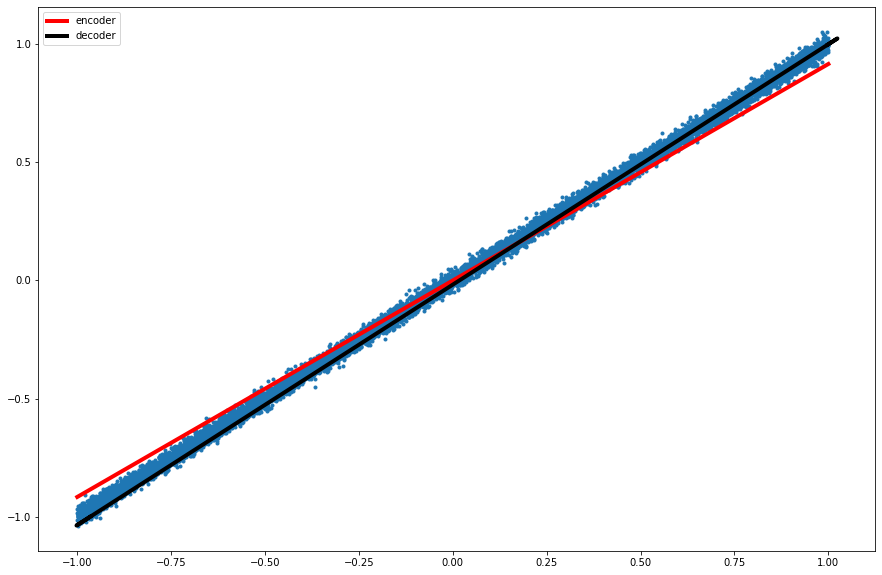

In [65]:
# plt.plot(data[:,0],data[:,1], '.')
eigenvec = model.state_dict()['encoder.weight'].numpy()
# eigenvec.shape

fig = plt.figure(figsize=(15,10))
plt.plot(data[:,0],data[:,1], '.')
plt.plot(data[:,0],(eigenvec[0][1]/eigenvec[0][0])*data[:,0], lw = 4, c='red', label = 'encoder')
plt.plot(out[:,0].detach().numpy(), out[:,1].detach().numpy(), lw = 4, c = 'black', label = 'decoder')
plt.legend()


NN as PCA has an extra degree of freedom beacause the encoder and decoder are independent operations.
To get the exact same behavior as PCA I believe I must tie the weights of encoder and decoder.

### PCA with NN + tied weights

In [47]:
import torch.nn.functional as F
# mixed approach
class MixedAppraochTiedAutoEncoder(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.decoder = nn.Linear(out, inp, bias=True)

    def forward(self, input):
        encoded_feats = F.linear(input, self.decoder.weight.t(), torch.dot(self.decoder.weight.t()[0], self.decoder.bias) )
        reconstructed_output = self.decoder(encoded_feats)
        return reconstructed_output #, encoded_feats, 

In [48]:
device = torch.device("cpu")
tied_model = MixedAppraochTiedAutoEncoder(2,1).to(device)

In [49]:
# loss function
criterion = nn.MSELoss()

# optimizer algorithm
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(tied_model.parameters(), lr=lr)

In [50]:
for it, epoch in enumerate(range(num_epochs)):
    # Ensure dropout layers are in train mode
    tied_model.train()

    # batch forward pass
    for i_batch, batch in tqdm(enumerate(my_dataloader)):
        # _ should be the target, which for cae its the image itself        
        x = batch[0].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the tied_model
        outputs = tied_model(x)
        # calculate the loss
        loss = criterion(outputs, x)
        # backward pass: compute gradient of the loss with respect to tied_model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

            
        # Print status
        if (i_batch + 1) % (len(my_dataloader) // print_freq) == 0:
            print(f'Epoch: [{epoch}] [{i_batch + 1}/ {len(my_dataloader)}] \t  \
                     Train Loss: {loss.item():.4f} ')
#             print(f'Train Loss: {loss.item()}')

2500it [00:02, 1147.08it/s]
105it [00:00, 1045.33it/s]

Epoch: [0] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1800.76it/s]
166it [00:00, 1655.55it/s]

Epoch: [1] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1416.12it/s]
96it [00:00, 959.53it/s]

Epoch: [2] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 906.91it/s]
94it [00:00, 939.66it/s]

Epoch: [3] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 911.59it/s]
134it [00:00, 1332.49it/s]

Epoch: [4] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1070.86it/s]
196it [00:00, 1955.95it/s]

Epoch: [5] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:01, 1303.86it/s]
98it [00:00, 971.71it/s]

Epoch: [6] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 919.09it/s]
91it [00:00, 909.18it/s]

Epoch: [7] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1082.17it/s]
186it [00:00, 1855.44it/s]

Epoch: [8] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1181.64it/s]
93it [00:00, 924.77it/s]

Epoch: [9] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 907.85it/s]
94it [00:00, 932.82it/s]

Epoch: [10] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 899.07it/s]
139it [00:00, 1383.21it/s]

Epoch: [11] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 944.57it/s]
91it [00:00, 903.41it/s]

Epoch: [12] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 901.33it/s]
99it [00:00, 986.20it/s]

Epoch: [13] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 934.20it/s]
96it [00:00, 951.28it/s]

Epoch: [14] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 935.96it/s] 
116it [00:00, 1153.04it/s]

Epoch: [15] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 951.38it/s] 
123it [00:00, 1227.11it/s]

Epoch: [16] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 922.45it/s]
93it [00:00, 926.33it/s]

Epoch: [17] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 909.03it/s]
96it [00:00, 959.20it/s]

Epoch: [18] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 907.42it/s]
90it [00:00, 895.95it/s]

Epoch: [19] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 901.17it/s]
92it [00:00, 914.36it/s]

Epoch: [20] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 895.33it/s]
96it [00:00, 949.49it/s]

Epoch: [21] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1038.37it/s]
120it [00:00, 1198.98it/s]

Epoch: [22] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1156.71it/s]
121it [00:00, 1207.83it/s]

Epoch: [23] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1075.50it/s]
125it [00:00, 1242.22it/s]

Epoch: [24] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1214.68it/s]
170it [00:00, 1695.60it/s]

Epoch: [25] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1080.81it/s]
91it [00:00, 903.47it/s]

Epoch: [26] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 932.24it/s]
93it [00:00, 926.93it/s]

Epoch: [27] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 906.61it/s]
97it [00:00, 965.42it/s]

Epoch: [28] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 967.94it/s] 
113it [00:00, 1124.29it/s]

Epoch: [29] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1022.42it/s]
157it [00:00, 1569.99it/s]

Epoch: [30] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 927.74it/s]
99it [00:00, 980.93it/s]

Epoch: [31] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 899.58it/s]
90it [00:00, 895.19it/s]

Epoch: [32] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 902.11it/s]
97it [00:00, 960.91it/s]

Epoch: [33] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 905.99it/s]
93it [00:00, 922.76it/s]

Epoch: [34] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 918.68it/s]
95it [00:00, 942.17it/s]

Epoch: [35] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 909.55it/s]
94it [00:00, 933.52it/s]

Epoch: [36] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 919.38it/s]
90it [00:00, 898.14it/s]

Epoch: [37] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 904.57it/s]
103it [00:00, 1028.38it/s]

Epoch: [38] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 994.53it/s] 
97it [00:00, 960.57it/s]

Epoch: [39] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 923.52it/s]
89it [00:00, 885.65it/s]

Epoch: [40] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 902.88it/s]
99it [00:00, 983.64it/s]

Epoch: [41] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 896.02it/s]
91it [00:00, 903.95it/s]

Epoch: [42] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 911.20it/s]
95it [00:00, 947.09it/s]

Epoch: [43] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 935.38it/s]
95it [00:00, 942.87it/s]

Epoch: [44] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 905.77it/s]
93it [00:00, 927.19it/s]

Epoch: [45] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 919.71it/s]
96it [00:00, 949.98it/s]

Epoch: [46] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 914.65it/s]
91it [00:00, 908.46it/s]

Epoch: [47] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 1083.68it/s]
90it [00:00, 898.46it/s]

Epoch: [48] [2500/ 2500] 	                       Train Loss: 0.0000 


2500it [00:02, 910.29it/s]

Epoch: [49] [2500/ 2500] 	                       Train Loss: 0.0000 


In [51]:
# Output of the tied_model

tied_model.eval()

out = []
# batch forward pass
for i_batch, batch in tqdm(enumerate(my_dataloader)):
    print(batch[0])
    out.append(tied_model(batch[0]))

93it [00:00, 924.34it/s]

tensor([[-1.0000, -0.9658],
        [-0.9998, -0.9867],
        [-0.9996, -1.0153],
        [-0.9994, -1.0400]])
tensor([[-0.9992, -0.9556],
        [-0.9990, -1.0129],
        [-0.9988, -0.9907],
        [-0.9986, -0.9918]])
tensor([[-0.9984, -1.0144],
        [-0.9982, -1.0186],
        [-0.9980, -0.9816],
        [-0.9978, -1.0299]])
tensor([[-0.9976, -0.9920],
        [-0.9974, -1.0004],
        [-0.9972, -1.0022],
        [-0.9970, -0.9953]])
tensor([[-0.9968, -0.9967],
        [-0.9966, -1.0259],
        [-0.9964, -0.9893],
        [-0.9962, -0.9841]])
tensor([[-0.9960, -1.0052],
        [-0.9958, -1.0160],
        [-0.9956, -1.0022],
        [-0.9954, -0.9635]])
tensor([[-0.9952, -0.9996],
        [-0.9950, -1.0030],
        [-0.9948, -0.9768],
        [-0.9946, -1.0265]])
tensor([[-0.9944, -1.0011],
        [-0.9942, -0.9730],
        [-0.9940, -0.9769],
        [-0.9938, -1.0208]])
tensor([[-0.9936, -0.9589],
        [-0.9934, -1.0051],
        [-0.9932, -0.9919],
        [-0.

204it [00:00, 971.25it/s]

tensor([[-0.8480, -0.8339],
        [-0.8478, -0.8252],
        [-0.8476, -0.8212],
        [-0.8474, -0.8471]])
tensor([[-0.8472, -0.8109],
        [-0.8470, -0.8644],
        [-0.8468, -0.8124],
        [-0.8466, -0.8699]])
tensor([[-0.8464, -0.8304],
        [-0.8462, -0.8330],
        [-0.8460, -0.8711],
        [-0.8458, -0.8295]])
tensor([[-0.8456, -0.8448],
        [-0.8454, -0.8388],
        [-0.8452, -0.8624],
        [-0.8450, -0.8556]])
tensor([[-0.8448, -0.8752],
        [-0.8446, -0.8323],
        [-0.8444, -0.8407],
        [-0.8442, -0.8560]])
tensor([[-0.8440, -0.8540],
        [-0.8438, -0.8806],
        [-0.8436, -0.8343],
        [-0.8434, -0.8452]])
tensor([[-0.8432, -0.8346],
        [-0.8430, -0.8358],
        [-0.8428, -0.8601],
        [-0.8426, -0.8564]])
tensor([[-0.8424, -0.8589],
        [-0.8422, -0.8481],
        [-0.8420, -0.8663],
        [-0.8418, -0.8360]])
tensor([[-0.8416, -0.8237],
        [-0.8414, -0.8141],
        [-0.8412, -0.8241],
        [-0.

303it [00:00, 976.44it/s]

tensor([[-0.8368, -0.8353],
        [-0.8366, -0.8282],
        [-0.8364, -0.8314],
        [-0.8362, -0.8452]])
tensor([[-0.8360, -0.8194],
        [-0.8358, -0.8513],
        [-0.8356, -0.8362],
        [-0.8354, -0.8216]])
tensor([[-0.8352, -0.8360],
        [-0.8350, -0.8073],
        [-0.8348, -0.8037],
        [-0.8346, -0.8041]])
tensor([[-0.8344, -0.8297],
        [-0.8342, -0.8269],
        [-0.8340, -0.8254],
        [-0.8338, -0.8093]])
tensor([[-0.8336, -0.8534],
        [-0.8334, -0.8248],
        [-0.8332, -0.8068],
        [-0.8330, -0.7862]])
tensor([[-0.8328, -0.8128],
        [-0.8326, -0.8107],
        [-0.8324, -0.8183],
        [-0.8322, -0.8417]])
tensor([[-0.8320, -0.8339],
        [-0.8318, -0.8377],
        [-0.8316, -0.8406],
        [-0.8314, -0.8293]])
tensor([[-0.8312, -0.8206],
        [-0.8310, -0.8136],
        [-0.8308, -0.8844],
        [-0.8306, -0.8085]])
tensor([[-0.8304, -0.8486],
        [-0.8302, -0.8134],
        [-0.8300, -0.8293],
        [-0.

404it [00:00, 985.82it/s]

tensor([[-0.6832, -0.6609],
        [-0.6830, -0.6523],
        [-0.6828, -0.6728],
        [-0.6826, -0.6387]])
tensor([[-0.6824, -0.6789],
        [-0.6822, -0.6810],
        [-0.6820, -0.6990],
        [-0.6818, -0.7069]])
tensor([[-0.6816, -0.6899],
        [-0.6814, -0.6891],
        [-0.6812, -0.7035],
        [-0.6810, -0.6756]])
tensor([[-0.6808, -0.6609],
        [-0.6806, -0.6975],
        [-0.6804, -0.6712],
        [-0.6802, -0.7035]])
tensor([[-0.6800, -0.6952],
        [-0.6798, -0.6680],
        [-0.6796, -0.6860],
        [-0.6794, -0.6864]])
tensor([[-0.6792, -0.7040],
        [-0.6790, -0.6938],
        [-0.6788, -0.6764],
        [-0.6786, -0.6816]])
tensor([[-0.6784, -0.6788],
        [-0.6782, -0.6888],
        [-0.6780, -0.6756],
        [-0.6778, -0.7123]])
tensor([[-0.6776, -0.6907],
        [-0.6774, -0.6831],
        [-0.6772, -0.7098],
        [-0.6770, -0.6678]])
tensor([[-0.6768, -0.6835],
        [-0.6766, -0.6428],
        [-0.6764, -0.6867],
        [-0.

495it [00:00, 960.56it/s]

tensor([[-0.6760, -0.6996],
        [-0.6758, -0.6634],
        [-0.6756, -0.6752],
        [-0.6754, -0.6977]])
tensor([[-0.6752, -0.6982],
        [-0.6750, -0.6559],
        [-0.6748, -0.6887],
        [-0.6746, -0.6728]])
tensor([[-0.6744, -0.6644],
        [-0.6742, -0.6922],
        [-0.6740, -0.6805],
        [-0.6738, -0.6661]])
tensor([[-0.6736, -0.6379],
        [-0.6734, -0.6915],
        [-0.6732, -0.6654],
        [-0.6730, -0.6530]])
tensor([[-0.6728, -0.7031],
        [-0.6726, -0.6631],
        [-0.6724, -0.6893],
        [-0.6722, -0.6714]])
tensor([[-0.6720, -0.6513],
        [-0.6718, -0.6671],
        [-0.6716, -0.6554],
        [-0.6714, -0.6734]])
tensor([[-0.6712, -0.7186],
        [-0.6710, -0.6617],
        [-0.6708, -0.6722],
        [-0.6706, -0.6470]])
tensor([[-0.6704, -0.7077],
        [-0.6702, -0.6991],
        [-0.6700, -0.6782],
        [-0.6698, -0.6389]])
tensor([[-0.6696, -0.6616],
        [-0.6694, -0.6598],
        [-0.6692, -0.6882],
        [-0.

580it [00:00, 923.10it/s]

tensor([[-0.5424, -0.5314],
        [-0.5422, -0.5407],
        [-0.5420, -0.5632],
        [-0.5418, -0.5641]])
tensor([[-0.5416, -0.5104],
        [-0.5414, -0.5276],
        [-0.5412, -0.5229],
        [-0.5410, -0.5202]])
tensor([[-0.5408, -0.5603],
        [-0.5406, -0.5700],
        [-0.5404, -0.5709],
        [-0.5402, -0.5299]])
tensor([[-0.5400, -0.5283],
        [-0.5398, -0.5385],
        [-0.5396, -0.5365],
        [-0.5394, -0.5457]])
tensor([[-0.5392, -0.5370],
        [-0.5390, -0.5441],
        [-0.5388, -0.5254],
        [-0.5386, -0.5223]])
tensor([[-0.5384, -0.5322],
        [-0.5382, -0.5471],
        [-0.5380, -0.5557],
        [-0.5378, -0.5617]])
tensor([[-0.5376, -0.5092],
        [-0.5374, -0.4890],
        [-0.5372, -0.5185],
        [-0.5370, -0.5066]])
tensor([[-0.5368, -0.5377],
        [-0.5366, -0.5321],
        [-0.5364, -0.5302],
        [-0.5362, -0.5102]])
tensor([[-0.5360, -0.5378],
        [-0.5358, -0.5530],
        [-0.5356, -0.5267],
        [-0.

703it [00:00, 997.70it/s]

tensor([[-0.5344, -0.5223],
        [-0.5342, -0.5200],
        [-0.5340, -0.5265],
        [-0.5338, -0.5598]])
tensor([[-0.5336, -0.5251],
        [-0.5334, -0.5264],
        [-0.5332, -0.5142],
        [-0.5330, -0.5392]])
tensor([[-0.5328, -0.5194],
        [-0.5326, -0.5717],
        [-0.5324, -0.5481],
        [-0.5322, -0.5686]])
tensor([[-0.5320, -0.5356],
        [-0.5318, -0.4929],
        [-0.5316, -0.5022],
        [-0.5314, -0.5472]])
tensor([[-0.5312, -0.5131],
        [-0.5310, -0.5294],
        [-0.5308, -0.5299],
        [-0.5306, -0.5325]])
tensor([[-0.5304, -0.5303],
        [-0.5302, -0.5230],
        [-0.5300, -0.5345],
        [-0.5298, -0.5471]])
tensor([[-0.5296, -0.5361],
        [-0.5294, -0.4631],
        [-0.5292, -0.5133],
        [-0.5290, -0.5107]])
tensor([[-0.5288, -0.5420],
        [-0.5286, -0.5050],
        [-0.5284, -0.4705],
        [-0.5282, -0.5343]])
tensor([[-0.5280, -0.5210],
        [-0.5278, -0.5258],
        [-0.5276, -0.5185],
        [-0.

tensor([[-0.3687, -0.3816],
        [-0.3685, -0.3639],
        [-0.3683, -0.3618],
        [-0.3681, -0.4527]])
tensor([[-0.3679, -0.4175],
        [-0.3677, -0.3678],
        [-0.3675, -0.3484],
        [-0.3673, -0.3827]])
tensor([[-0.3671, -0.3552],
        [-0.3669, -0.3585],
        [-0.3667, -0.3625],
        [-0.3665, -0.3512]])
tensor([[-0.3663, -0.3638],
        [-0.3661, -0.3534],
        [-0.3659, -0.3652],
        [-0.3657, -0.3818]])
tensor([[-0.3655, -0.3488],
        [-0.3653, -0.3856],
        [-0.3651, -0.3625],
        [-0.3649, -0.3734]])
tensor([[-0.3647, -0.3380],
        [-0.3645, -0.3766],
        [-0.3643, -0.3736],
        [-0.3641, -0.3624]])
tensor([[-0.3639, -0.3811],
        [-0.3637, -0.3632],
        [-0.3635, -0.3738],
        [-0.3633, -0.3918]])
tensor([[-0.3631, -0.3461],
        [-0.3629, -0.3405],
        [-0.3627, -0.3863],
        [-0.3625, -0.3522]])
tensor([[-0.3623, -0.3673],
        [-0.3621, -0.3202],
        [-0.3619, -0.3548],
        [-0.

895it [00:00, 967.75it/s]

tensor([[-0.3615, -0.3609],
        [-0.3613, -0.3716],
        [-0.3611, -0.3613],
        [-0.3609, -0.3478]])
tensor([[-0.3607, -0.3762],
        [-0.3605, -0.3356],
        [-0.3603, -0.3701],
        [-0.3601, -0.3552]])
tensor([[-0.3599, -0.3554],
        [-0.3597, -0.3735],
        [-0.3595, -0.3297],
        [-0.3593, -0.3585]])
tensor([[-0.3591, -0.3741],
        [-0.3589, -0.3488],
        [-0.3587, -0.3754],
        [-0.3585, -0.3625]])
tensor([[-0.3583, -0.3665],
        [-0.3581, -0.3252],
        [-0.3579, -0.3452],
        [-0.3577, -0.3823]])
tensor([[-0.3575, -0.3689],
        [-0.3573, -0.3679],
        [-0.3571, -0.3361],
        [-0.3569, -0.3388]])
tensor([[-0.3567, -0.3921],
        [-0.3565, -0.3607],
        [-0.3563, -0.3561],
        [-0.3561, -0.3589]])
tensor([[-0.3559, -0.3658],
        [-0.3557, -0.3615],
        [-0.3555, -0.3503],
        [-0.3553, -0.3165]])
tensor([[-0.3551, -0.3586],
        [-0.3549, -0.3481],
        [-0.3547, -0.3641],
        [-0.

tensor([[-0.2279, -0.2112],
        [-0.2277, -0.2683],
        [-0.2275, -0.2606],
        [-0.2273, -0.2186]])
tensor([[-0.2271, -0.2550],
        [-0.2269, -0.2085],
        [-0.2267, -0.2713],
        [-0.2265, -0.2542]])
tensor([[-0.2263, -0.2396],
        [-0.2261, -0.2401],
        [-0.2259, -0.2635],
        [-0.2257, -0.2226]])
tensor([[-0.2255, -0.2497],
        [-0.2253, -0.2201],
        [-0.2251, -0.2473],
        [-0.2249, -0.1875]])
tensor([[-0.2247, -0.1998],
        [-0.2245, -0.2489],
        [-0.2243, -0.2381],
        [-0.2241, -0.2180]])
tensor([[-0.2239, -0.2037],
        [-0.2237, -0.2223],
        [-0.2235, -0.2339],
        [-0.2233, -0.2115]])
tensor([[-0.2231, -0.2570],
        [-0.2229, -0.2598],
        [-0.2227, -0.2594],
        [-0.2225, -0.2205]])
tensor([[-0.2223, -0.1805],
        [-0.2221, -0.1923],
        [-0.2219, -0.2063],
        [-0.2217, -0.2729]])
tensor([[-0.2215, -0.2254],
        [-0.2213, -0.2103],
        [-0.2211, -0.2109],
        [-0.

1106it [00:01, 975.88it/s]

tensor([[-0.2199, -0.2382],
        [-0.2197, -0.2365],
        [-0.2195, -0.2332],
        [-0.2193, -0.2383]])
tensor([[-0.2191, -0.2352],
        [-0.2189, -0.2221],
        [-0.2187, -0.2139],
        [-0.2185, -0.1996]])
tensor([[-0.2183, -0.2178],
        [-0.2181, -0.2213],
        [-0.2179, -0.1844],
        [-0.2177, -0.2186]])
tensor([[-0.2175, -0.2289],
        [-0.2173, -0.2183],
        [-0.2171, -0.2272],
        [-0.2169, -0.2315]])
tensor([[-0.2167, -0.2343],
        [-0.2165, -0.2259],
        [-0.2163, -0.2388],
        [-0.2161, -0.1812]])
tensor([[-0.2159, -0.2426],
        [-0.2157, -0.2452],
        [-0.2155, -0.2551],
        [-0.2153, -0.2071]])
tensor([[-0.2151, -0.2145],
        [-0.2149, -0.2375],
        [-0.2147, -0.2334],
        [-0.2145, -0.1983]])
tensor([[-0.2143, -0.2400],
        [-0.2141, -0.2141],
        [-0.2139, -0.2164],
        [-0.2137, -0.2173]])
tensor([[-0.2135, -0.2223],
        [-0.2133, -0.2046],
        [-0.2131, -0.2078],
        [-0.

tensor([[-0.0695, -0.0802],
        [-0.0693, -0.0557],
        [-0.0691, -0.0933],
        [-0.0689, -0.0784]])
tensor([[-0.0687, -0.0251],
        [-0.0685, -0.0354],
        [-0.0683, -0.0356],
        [-0.0681, -0.0591]])
tensor([[-0.0679, -0.0832],
        [-0.0677, -0.0918],
        [-0.0675, -0.0421],
        [-0.0673, -0.0282]])
tensor([[-0.0671, -0.1129],
        [-0.0669, -0.0655],
        [-0.0667, -0.0434],
        [-0.0665, -0.0372]])
tensor([[-0.0663, -0.0592],
        [-0.0661, -0.0673],
        [-0.0659, -0.0633],
        [-0.0657, -0.0530]])
tensor([[-0.0655, -0.0715],
        [-0.0653, -0.0495],
        [-0.0651, -0.0622],
        [-0.0649, -0.0523]])
tensor([[-0.0647, -0.0668],
        [-0.0645, -0.0537],
        [-0.0643, -0.1084],
        [-0.0641, -0.0741]])
tensor([[-0.0639, -0.0412],
        [-0.0637, -0.0659],
        [-0.0635, -0.0793],
        [-0.0633, -0.0346]])
tensor([[-0.0631, -0.0675],
        [-0.0629, -0.0697],
        [-0.0627, -0.0410],
        [-0.

1315it [00:01, 975.55it/s]

tensor([[-0.0623, -0.0742],
        [-0.0621, -0.0499],
        [-0.0619, -0.0430],
        [-0.0617, -0.0269]])
tensor([[-0.0615, -0.0501],
        [-0.0613, -0.0453],
        [-0.0611, -0.0548],
        [-0.0609, -0.0517]])
tensor([[-0.0607, -0.0718],
        [-0.0605, -0.0637],
        [-0.0603, -0.0433],
        [-0.0601, -0.0283]])
tensor([[-0.0599, -0.0309],
        [-0.0597, -0.0891],
        [-0.0595, -0.0477],
        [-0.0593, -0.0405]])
tensor([[-0.0591, -0.0527],
        [-0.0589, -0.0329],
        [-0.0587, -0.0419],
        [-0.0585, -0.0773]])
tensor([[-0.0583, -0.0714],
        [-0.0581, -0.0847],
        [-0.0579, -0.0431],
        [-0.0577, -0.0630]])
tensor([[-0.0575, -0.0780],
        [-0.0573, -0.0283],
        [-0.0571, -0.0608],
        [-0.0569, -0.0316]])
tensor([[-0.0567, -0.0473],
        [-0.0565, -0.0500],
        [-0.0563, -0.0537],
        [-0.0561, -0.0616]])
tensor([[-0.0559, -0.0638],
        [-0.0557, -0.0257],
        [-0.0555, -0.0674],
        [-0.

tensor([[0.0929, 0.0701],
        [0.0931, 0.0740],
        [0.0933, 0.0918],
        [0.0935, 0.1086]])
tensor([[0.0937, 0.1228],
        [0.0939, 0.0955],
        [0.0941, 0.0657],
        [0.0943, 0.0919]])
tensor([[0.0945, 0.0580],
        [0.0947, 0.0792],
        [0.0949, 0.1245],
        [0.0951, 0.1017]])
tensor([[0.0953, 0.1297],
        [0.0955, 0.0796],
        [0.0957, 0.0695],
        [0.0959, 0.0827]])
tensor([[0.0961, 0.0760],
        [0.0963, 0.0856],
        [0.0965, 0.0804],
        [0.0967, 0.1130]])
tensor([[0.0969, 0.1075],
        [0.0971, 0.0660],
        [0.0973, 0.1102],
        [0.0975, 0.1161]])
tensor([[0.0977, 0.1113],
        [0.0979, 0.1112],
        [0.0981, 0.0871],
        [0.0983, 0.1125]])


1510it [00:01, 936.34it/s]

tensor([[0.0985, 0.0768],
        [0.0987, 0.1045],
        [0.0989, 0.0806],
        [0.0991, 0.0903]])
tensor([[0.0993, 0.0720],
        [0.0995, 0.1086],
        [0.0997, 0.0794],
        [0.0999, 0.1128]])
tensor([[0.1001, 0.1362],
        [0.1003, 0.1342],
        [0.1005, 0.1168],
        [0.1007, 0.1336]])
tensor([[0.1009, 0.0887],
        [0.1011, 0.1039],
        [0.1013, 0.0924],
        [0.1015, 0.1279]])
tensor([[0.1017, 0.0743],
        [0.1019, 0.0723],
        [0.1021, 0.1098],
        [0.1023, 0.0730]])
tensor([[0.1025, 0.0727],
        [0.1027, 0.0600],
        [0.1029, 0.0979],
        [0.1031, 0.0908]])
tensor([[0.1033, 0.1119],
        [0.1035, 0.1185],
        [0.1037, 0.1359],
        [0.1039, 0.1292]])
tensor([[0.1041, 0.0947],
        [0.1043, 0.0898],
        [0.1045, 0.1405],
        [0.1047, 0.0958]])
tensor([[0.1049, 0.1194],
        [0.1051, 0.1390],
        [0.1053, 0.1036],
        [0.1055, 0.0520]])
tensor([[0.1057, 0.1191],
        [0.1059, 0.1319],
   

tensor([[0.2417, 0.2519],
        [0.2419, 0.2655],
        [0.2421, 0.2388],
        [0.2423, 0.2587]])
tensor([[0.2425, 0.2867],
        [0.2427, 0.2482],
        [0.2429, 0.2335],
        [0.2431, 0.2863]])
tensor([[0.2433, 0.2364],
        [0.2435, 0.2226],
        [0.2437, 0.2892],
        [0.2439, 0.2354]])
tensor([[0.2441, 0.2396],
        [0.2443, 0.2466],
        [0.2445, 0.2302],
        [0.2447, 0.2523]])
tensor([[0.2449, 0.2537],
        [0.2451, 0.2454],
        [0.2453, 0.2473],
        [0.2455, 0.2079]])
tensor([[0.2457, 0.2723],
        [0.2459, 0.2387],
        [0.2461, 0.2255],
        [0.2463, 0.2610]])
tensor([[0.2465, 0.2421],
        [0.2467, 0.2807],
        [0.2469, 0.2785],
        [0.2471, 0.2274]])
tensor([[0.2473, 0.2573],
        [0.2475, 0.2354],
        [0.2477, 0.2446],
        [0.2479, 0.2300]])
tensor([[0.2481, 0.2067],
        [0.2483, 0.2151],
        [0.2485, 0.2237],
        [0.2487, 0.2302]])
tensor([[0.2489, 0.2691],
        [0.2491, 0.2152],
   

1718it [00:01, 987.84it/s]

tensor([[0.2505, 0.2234],
        [0.2507, 0.2376],
        [0.2509, 0.2632],
        [0.2511, 0.2298]])
tensor([[0.2513, 0.2583],
        [0.2515, 0.2481],
        [0.2517, 0.2270],
        [0.2519, 0.2509]])
tensor([[0.2521, 0.2735],
        [0.2523, 0.2554],
        [0.2525, 0.2648],
        [0.2527, 0.2956]])
tensor([[0.2529, 0.2811],
        [0.2531, 0.2341],
        [0.2533, 0.2534],
        [0.2535, 0.2821]])
tensor([[0.2537, 0.2566],
        [0.2539, 0.2589],
        [0.2541, 0.2520],
        [0.2543, 0.2205]])
tensor([[0.2545, 0.2638],
        [0.2547, 0.2499],
        [0.2549, 0.2760],
        [0.2551, 0.2332]])
tensor([[0.2553, 0.2229],
        [0.2555, 0.2385],
        [0.2557, 0.2725],
        [0.2559, 0.2655]])
tensor([[0.2561, 0.2707],
        [0.2563, 0.2766],
        [0.2565, 0.2524],
        [0.2567, 0.2644]])
tensor([[0.2569, 0.2336],
        [0.2571, 0.2621],
        [0.2573, 0.3047],
        [0.2575, 0.2534]])
tensor([[0.2577, 0.2488],
        [0.2579, 0.2620],
   

tensor([[0.4145, 0.4273],
        [0.4147, 0.3947],
        [0.4149, 0.3951],
        [0.4151, 0.3925]])
tensor([[0.4153, 0.3914],
        [0.4155, 0.4144],
        [0.4157, 0.4257],
        [0.4159, 0.3875]])
tensor([[0.4161, 0.4280],
        [0.4163, 0.4425],
        [0.4165, 0.4646],
        [0.4167, 0.4219]])
tensor([[0.4169, 0.3977],
        [0.4171, 0.3845],
        [0.4173, 0.4189],
        [0.4175, 0.4020]])
tensor([[0.4177, 0.4557],
        [0.4179, 0.4314],
        [0.4181, 0.4295],
        [0.4183, 0.4493]])
tensor([[0.4185, 0.4198],
        [0.4187, 0.4025],
        [0.4189, 0.3957],
        [0.4191, 0.4382]])
tensor([[0.4193, 0.4247],
        [0.4195, 0.4060],
        [0.4197, 0.4146],
        [0.4199, 0.3940]])
tensor([[0.4201, 0.4508],
        [0.4203, 0.4237],
        [0.4205, 0.4376],
        [0.4207, 0.4251]])
tensor([[0.4209, 0.3938],
        [0.4211, 0.4267],
        [0.4213, 0.4007],
        [0.4215, 0.4116]])
tensor([[0.4217, 0.4190],
        [0.4219, 0.3910],
   

1965it [00:01, 1100.61it/s]

tensor([[0.4233, 0.4306],
        [0.4235, 0.4499],
        [0.4237, 0.3999],
        [0.4239, 0.4106]])
tensor([[0.4241, 0.4228],
        [0.4243, 0.4336],
        [0.4245, 0.4583],
        [0.4247, 0.4115]])
tensor([[0.4249, 0.4442],
        [0.4251, 0.4360],
        [0.4253, 0.4328],
        [0.4255, 0.4073]])
tensor([[0.4257, 0.4181],
        [0.4259, 0.4012],
        [0.4261, 0.4133],
        [0.4263, 0.4159]])
tensor([[0.4265, 0.4442],
        [0.4267, 0.4227],
        [0.4269, 0.4286],
        [0.4271, 0.4176]])
tensor([[0.4273, 0.4506],
        [0.4275, 0.4433],
        [0.4277, 0.4236],
        [0.4279, 0.4229]])
tensor([[0.4281, 0.4284],
        [0.4283, 0.4168],
        [0.4285, 0.4587],
        [0.4287, 0.4353]])
tensor([[0.4289, 0.4506],
        [0.4291, 0.4208],
        [0.4293, 0.4194],
        [0.4295, 0.4348]])
tensor([[0.4297, 0.4570],
        [0.4299, 0.4306],
        [0.4301, 0.4193],
        [0.4303, 0.4595]])
tensor([[0.4305, 0.4743],
        [0.4307, 0.4248],
   

tensor([[0.6146, 0.6029],
        [0.6148, 0.6164],
        [0.6150, 0.6039],
        [0.6152, 0.6150]])
tensor([[0.6154, 0.5820],
        [0.6156, 0.5835],
        [0.6158, 0.6056],
        [0.6160, 0.6279]])
tensor([[0.6162, 0.5829],
        [0.6164, 0.5986],
        [0.6166, 0.6095],
        [0.6168, 0.6365]])
tensor([[0.6170, 0.6252],
        [0.6172, 0.6598],
        [0.6174, 0.5955],
        [0.6176, 0.6418]])
tensor([[0.6178, 0.6208],
        [0.6180, 0.6209],
        [0.6182, 0.5892],
        [0.6184, 0.6068]])
tensor([[0.6186, 0.6349],
        [0.6188, 0.6427],
        [0.6190, 0.6315],
        [0.6192, 0.6084]])
tensor([[0.6194, 0.6109],
        [0.6196, 0.5994],
        [0.6198, 0.6142],
        [0.6200, 0.6121]])
tensor([[0.6202, 0.6251],
        [0.6204, 0.5952],
        [0.6206, 0.6106],
        [0.6208, 0.6352]])
tensor([[0.6210, 0.6189],
        [0.6212, 0.6468],
        [0.6214, 0.6291],
        [0.6216, 0.6100]])
tensor([[0.6218, 0.6548],
        [0.6220, 0.6072],
   

2209it [00:02, 1155.70it/s]

tensor([[0.6234, 0.6215],
        [0.6236, 0.6187],
        [0.6238, 0.6302],
        [0.6240, 0.6081]])
tensor([[0.6242, 0.6248],
        [0.6244, 0.6194],
        [0.6246, 0.6379],
        [0.6248, 0.6220]])
tensor([[0.6250, 0.6242],
        [0.6252, 0.6140],
        [0.6254, 0.6161],
        [0.6256, 0.6548]])
tensor([[0.6258, 0.6103],
        [0.6260, 0.6272],
        [0.6262, 0.6112],
        [0.6264, 0.5904]])
tensor([[0.6266, 0.6549],
        [0.6268, 0.6506],
        [0.6270, 0.6001],
        [0.6272, 0.6704]])
tensor([[0.6274, 0.6514],
        [0.6276, 0.6046],
        [0.6278, 0.6182],
        [0.6280, 0.6370]])
tensor([[0.6282, 0.6318],
        [0.6284, 0.6097],
        [0.6286, 0.5888],
        [0.6288, 0.5942]])
tensor([[0.6290, 0.6413],
        [0.6292, 0.6258],
        [0.6294, 0.6244],
        [0.6296, 0.6451]])
tensor([[0.6298, 0.6435],
        [0.6300, 0.5949],
        [0.6302, 0.6531],
        [0.6304, 0.6826]])
tensor([[0.6306, 0.6341],
        [0.6308, 0.6098],
   

tensor([[0.8138, 0.8208],
        [0.8140, 0.8236],
        [0.8142, 0.7864],
        [0.8144, 0.8299]])
tensor([[0.8146, 0.7806],
        [0.8148, 0.7995],
        [0.8150, 0.7929],
        [0.8152, 0.8192]])
tensor([[0.8154, 0.7999],
        [0.8156, 0.8199],
        [0.8158, 0.8060],
        [0.8160, 0.7940]])
tensor([[0.8162, 0.7889],
        [0.8164, 0.8425],
        [0.8166, 0.8257],
        [0.8168, 0.8276]])
tensor([[0.8170, 0.8364],
        [0.8172, 0.8174],
        [0.8174, 0.8152],
        [0.8176, 0.8254]])
tensor([[0.8178, 0.8387],
        [0.8180, 0.8424],
        [0.8182, 0.8462],
        [0.8184, 0.8090]])
tensor([[0.8186, 0.8067],
        [0.8188, 0.8172],
        [0.8190, 0.8054],
        [0.8192, 0.8018]])
tensor([[0.8194, 0.8433],
        [0.8196, 0.8159],
        [0.8198, 0.8257],
        [0.8200, 0.7894]])
tensor([[0.8202, 0.8484],
        [0.8204, 0.8125],
        [0.8206, 0.8110],
        [0.8208, 0.7941]])
tensor([[0.8210, 0.8378],
        [0.8212, 0.7946],
   

2456it [00:02, 1098.97it/s]

tensor([[0.8234, 0.8254],
        [0.8236, 0.7970],
        [0.8238, 0.8663],
        [0.8240, 0.8149]])
tensor([[0.8242, 0.8435],
        [0.8244, 0.8400],
        [0.8246, 0.8431],
        [0.8248, 0.8090]])
tensor([[0.8250, 0.8266],
        [0.8252, 0.8370],
        [0.8254, 0.8271],
        [0.8256, 0.8438]])
tensor([[0.8258, 0.8208],
        [0.8260, 0.7887],
        [0.8262, 0.8366],
        [0.8264, 0.8052]])
tensor([[0.8266, 0.8102],
        [0.8268, 0.8055],
        [0.8270, 0.8332],
        [0.8272, 0.8127]])
tensor([[0.8274, 0.8321],
        [0.8276, 0.8241],
        [0.8278, 0.8354],
        [0.8280, 0.8121]])
tensor([[0.8282, 0.8408],
        [0.8284, 0.8548],
        [0.8286, 0.8023],
        [0.8288, 0.8095]])
tensor([[0.8290, 0.8310],
        [0.8292, 0.8283],
        [0.8294, 0.8268],
        [0.8296, 0.8344]])
tensor([[0.8298, 0.8375],
        [0.8300, 0.8362],
        [0.8302, 0.8164],
        [0.8304, 0.8200]])
tensor([[0.8306, 0.8214],
        [0.8308, 0.8191],
   

tensor([[0.9826, 0.9264],
        [0.9828, 0.9856],
        [0.9830, 0.9745],
        [0.9832, 0.9792]])
tensor([[0.9834, 0.9869],
        [0.9836, 0.9507],
        [0.9838, 1.0116],
        [0.9840, 0.9753]])
tensor([[0.9842, 1.0512],
        [0.9844, 0.9773],
        [0.9846, 1.0203],
        [0.9848, 1.0024]])
tensor([[0.9850, 0.9901],
        [0.9852, 0.9722],
        [0.9854, 1.0453],
        [0.9856, 0.9935]])
tensor([[0.9858, 1.0261],
        [0.9860, 0.9843],
        [0.9862, 0.9915],
        [0.9864, 1.0063]])
tensor([[0.9866, 0.9678],
        [0.9868, 0.9753],
        [0.9870, 0.9642],
        [0.9872, 0.9809]])
tensor([[0.9874, 0.9639],
        [0.9876, 1.0391],
        [0.9878, 1.0265],
        [0.9880, 0.9700]])
tensor([[0.9882, 1.0025],
        [0.9884, 1.0198],
        [0.9886, 0.9975],
        [0.9888, 0.9827]])
tensor([[0.9890, 0.9833],
        [0.9892, 1.0260],
        [0.9894, 0.9574],
        [0.9896, 0.9946]])
tensor([[0.9898, 0.9896],
        [0.9900, 0.9709],
   

2500it [00:02, 1028.55it/s]

tensor([[0.9914, 0.9707],
        [0.9916, 1.0009],
        [0.9918, 0.9594],
        [0.9920, 1.0278]])
tensor([[0.9922, 0.9830],
        [0.9924, 1.0369],
        [0.9926, 0.9762],
        [0.9928, 0.9803]])
tensor([[0.9930, 0.9840],
        [0.9932, 0.9828],
        [0.9934, 1.0039],
        [0.9936, 0.9856]])
tensor([[0.9938, 0.9992],
        [0.9940, 1.0259],
        [0.9942, 1.0016],
        [0.9944, 0.9976]])
tensor([[0.9946, 1.0182],
        [0.9948, 1.0048],
        [0.9950, 0.9660],
        [0.9952, 0.9737]])
tensor([[0.9954, 0.9788],
        [0.9956, 0.9811],
        [0.9958, 0.9802],
        [0.9960, 1.0525]])
tensor([[0.9962, 1.0003],
        [0.9964, 1.0056],
        [0.9966, 0.9829],
        [0.9968, 1.0009]])
tensor([[0.9970, 1.0025],
        [0.9972, 1.0168],
        [0.9974, 0.9739],
        [0.9976, 0.9678]])
tensor([[0.9978, 0.9756],
        [0.9980, 1.0263],
        [0.9982, 0.9678],
        [0.9984, 1.0073]])
tensor([[0.9986, 1.0132],
        [0.9988, 0.9976],
   

In [52]:
print(len(out))
out = torch.cat(out,0)
out.shape

2500


torch.Size([10000, 2])

In [69]:
# plt.plot(data[:,0],data[:,1], '.')
tied_eigenvec = tied_model.state_dict()['decoder.weight'].numpy()
tied_eigenvec = tied_eigenvec.T
# eigenvec.shape


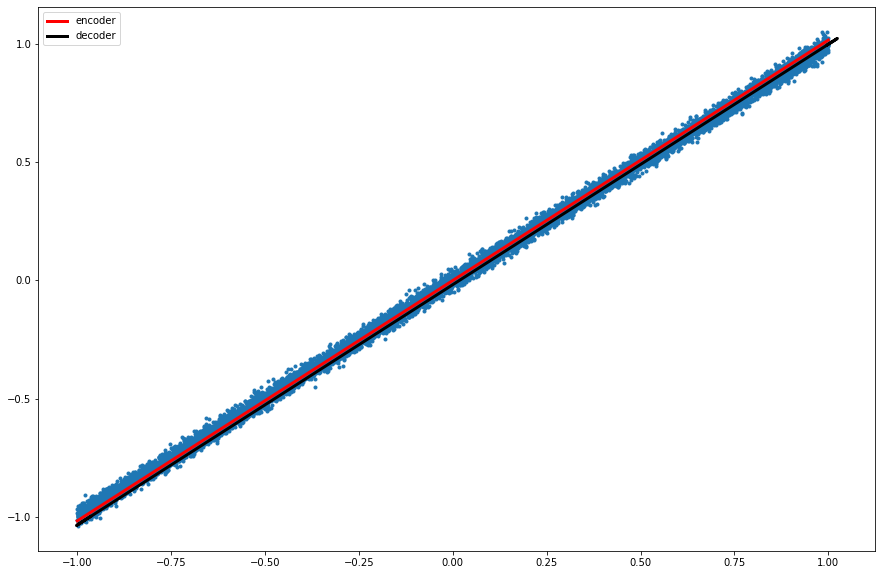

In [70]:
fig = plt.figure(figsize=(15,10))
plt.plot(data[:,0],data[:,1], '.')
plt.plot(data[:,0],(tied_eigenvec[0][1]/tied_eigenvec[0][0])*data[:,0], lw = 3, c='red', label = 'encoder')
plt.plot(out[:,0].detach().numpy(), out[:,1].detach().numpy(), lw = 3, c = 'black', label = 'decoder')
plt.legend()

In [204]:

# data
x = np.linspace(-1,1,80)
# true slope
m_t = 1

def noisy_lin(x,m,b):
    
    y = m*x + b + np.random.normal(loc=0.0, scale=0.4, size=len(x))
    
    
    return y

y = noisy_lin(x,m_t,0)


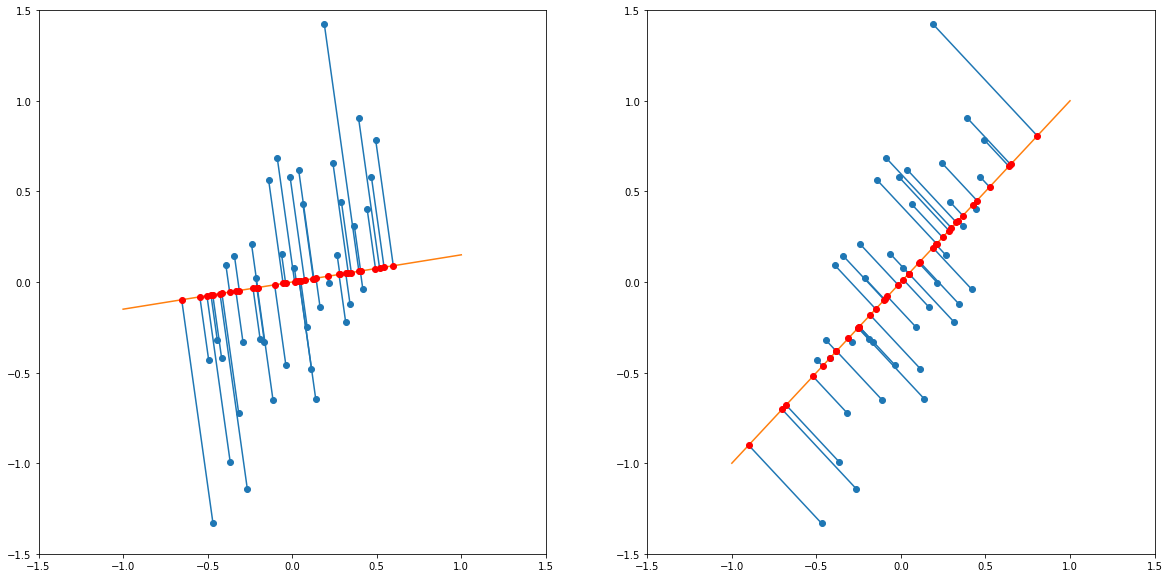

In [207]:
import matplotlib.lines as lines

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(122)


m = 1
limit =1.5
cut = 20
alpha = np.arctan(m)





x_proj = []
y_proj = []
for xi,yi in zip(x[cut:-cut],y[cut:-cut]):
    dist = (yi - m*xi)*np.sin(alpha)
    deltax = dist*np.cos(alpha)
    deltay = dist*np.sin(alpha)
    x_proj.append(xi+deltax)
    y_proj.append(m*xi+deltay)
    ax.add_line(lines.Line2D([xi, xi+deltax], [yi, m*xi+deltay]))   
#     ax.add_line(lines.Line2D([xi, xi], [yi, m*xi]))   
#     ax.add_line(lines.Line2D([xi, xi], [m*xi, m*xi+dist]))   
    
    

ax.set_xlim([-limit,limit])
ax.set_ylim([-limit,limit])
# ax.add_line(lines.Line2D([0,1],[0,1]))
    
    
    
    
                   
    
    
 
    
# fig.lines.extend(line_ls)


ax.plot(x[cut:-cut],y[cut:-cut],'o')

ax.plot(x,m*x,'-')
ax.plot(x_proj,y_proj, 'o', c='r')

ax1 = fig.add_subplot(121)

m = .15
alpha = np.arctan(m)





x_proj = []
y_proj = []
for xi,yi in zip(x[cut:-cut],y[cut:-cut]):
    dist = (yi - m*xi)*np.sin(alpha)
    deltax = dist*np.cos(alpha)
    deltay = dist*np.sin(alpha)
    x_proj.append(xi+deltax)
    y_proj.append(m*xi+deltay)
    ax1.add_line(lines.Line2D([xi, xi+deltax], [yi, m*xi+deltay]))   
#     ax.add_line(lines.Line2D([xi, xi], [yi, m*xi]))   
#     ax.add_line(lines.Line2D([xi, xi], [m*xi, m*xi+dist]))   
    
    

ax1.set_xlim([-limit,limit])
ax1.set_ylim([-limit,limit])


ax1.plot(x[cut:-cut],y[cut:-cut],ls='',marker='o')

ax1.plot(x,m*x,'-')
ax1.plot(x_proj,y_proj,'o', c='r')

In [88]:
np.pi/4

0.7853981633974483